# **Disciplina CAT314** - Ferramentas de Previsão de Curtíssimo Prazo (nowcasting)


---





## **Aula Prática 1:** $\underline{Trabalhando\ com\ dados\ de\ Radiossondagens}$

---


**OBJETIVO:** Nesta aula prática aprenderemos como baixar  e plotar dados de radiossondagens. Para isto será utilizado os dados da Universidade de [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).



---


**DADOS DE ENTRADA**: Arquivos texto de radiossondagem.

- **Tipo do dado:** tabela  
- **Formato do dado:** arquivo TEXTO
- **Nome do arquivo:** Não tem
- **Fonte dos dados:** http://weather.uwyo.edu/upperair/sounding.html



---

**DADOS DE SAÍDA:** Figura e arquivo CSV
- **Tipo do dado:** Figura e tabela
- **Formato do dado:** arquivo JPG e CSV
- **Imagens geradas:**
    1. skewt_SBGL_2022-10-30 12:00:00.jpg
    2. SBGL_2022-10-30 12:00:00.csv



---



**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:

1.   Download dos dados de uma sondagem atmosférica para uma determinada data/horário;
2.   Tratamento dos dados (eliminação de dados ausentes);
3.   Cálculo dos índices termodinâmicos;
4.   Plotagem do Skew-T Log-P com a Hodógrafa;
5.   Salvar os dados em arquivo csv.


---




**OBSERVAÇÕES IMPORTANTES**:
1. Mudar o caminho para o do seu drive.
2. Escolher a estação de radiossondagem. A escolha pode ser realizada inserindo o `código númerico` ou a `sigla` da estação.
3. Escolher a `data/horário` da radiossondagem.



---

- **Realizado por:** [Willy Hagi](https://taggo.one/willyhagi) da Meteonorte
- **Atualizado por:** Enrique V. Mattos - 22/10/2021, Atualizado em: 19/09/2024


---


**Exemplo do gráfico que será gerado nessa aula:**

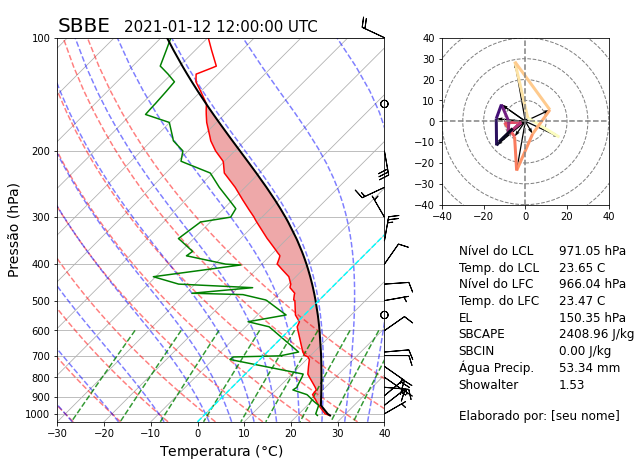

# **1° Passo:** Instalando o `Siphon`
O [`Siphon`](https://github.com/Unidata/siphon) é um pacote que reúne uma coleção de funcionalidades que permitem o acesso de alguns bancos de dados meteorológicos. Para a nossa aula prática, vamos acessar o banco de dados de radiossondagens mantido pela [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).

Outros bancos de dados:
* *Integrated Global Radiosonde Archive version 2* (IGRA v2);
* *Iowa State’s upper air archive*;
* *National Data Buoy Center* (NDBC).

Vamos instalar o `Siphon` no **Colab**:

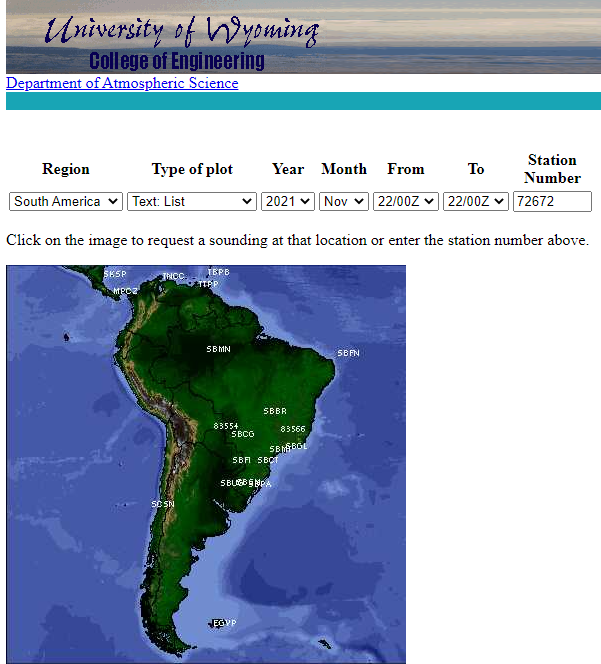

In [ ]:
!pip install -q siphon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 1.8 MB/s eta 0:00:00


# **2° Passo:** Instalando o `MetPy`
O [`MetPy`](https://unidata.github.io/MetPy/latest/index.html) foi um dos primeiros pacotes voltados exclusivamente para meteorologia no ecossistema científico do Python. É mantido até hoje pela UCAR/UNIDATA e por uma série de pesquisadores/programadores voluntários.

Vamos instalar o `MetPy` no **Colab**:

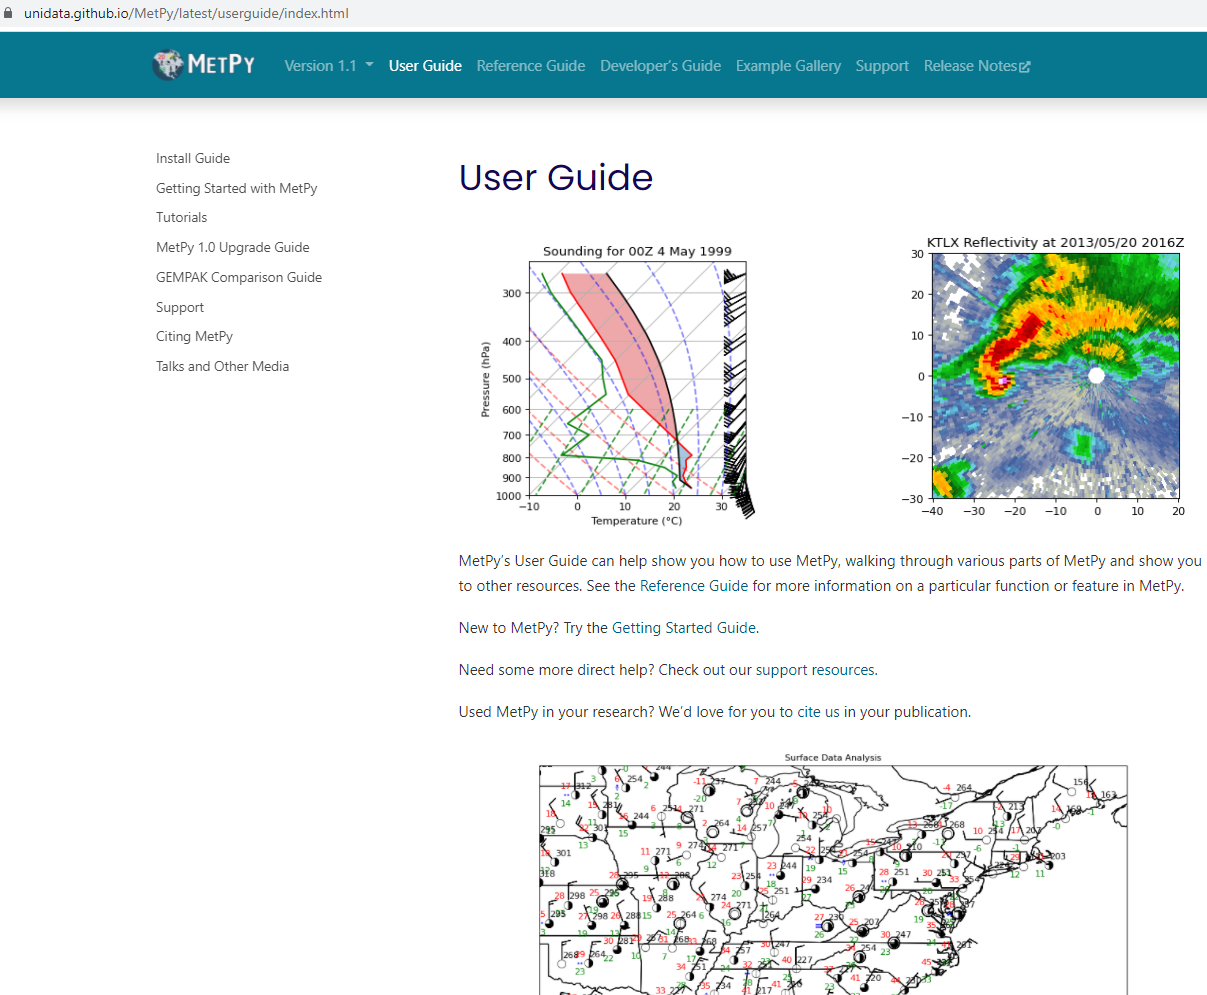

In [ ]:
!pip install -q metpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.4/424.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 15.4 MB/s eta 0:00:00


# **3° Passo:** Importando Bibliotecas

In [ ]:
# Exemplo: import nome_biblioteca as apelido

import numpy as np                                           # biblioteca para trabalhar com matrizes
from datetime import datetime                                # biblioteca para trabalhar com datas

from siphon.simplewebservice.wyoming import WyomingUpperAir  # biblioteca siphon para baixar os dados de radiossodagens

from metpy.units import units                                # função unidades do metpy
import metpy.calc as mpcalc                                  # função que calcula variáveis termodinâmicas do metpy
from metpy.plots import Hodograph                            # função que plota hodógrafa do metpy
from metpy.plots import SkewT                                # função que plota o gráfico Skew-T do metpy

import matplotlib.pyplot as plt                              # biblioteca para plotar gráficos
import matplotlib.gridspec as gridspec                       # função do matplotlib para plotar várias sub-figuras em uma figura
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # função do matplotlib para inserir eixos em uma figura

# **4° Passo:** Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **5° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [ ]:
# nome do diretório
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/2_SEGUNDO_SEMESTRE/CAT314 - FERRAMENTAS DE PREVISÃO DE CURTÍSSIMO PRAZO (NOWCASTING) /AULAS/CAT314 - PYTHON PARA NOWCASTING'

In [ ]:
# cria a pasta de saída com o nome "output"
import os

dir_output = f'{dir}/output/aula_01/'

os.makedirs(dir_output, exist_ok=True)

# **6° Passo:** Declarando a função

* Função que baixa e plota os dados de uma radissondagem

In [ ]:
def plotar_painel(p, t, td, niveis, nome_estacao, hora, seu_nome, dir):

  pressao = p
  temperatura = t
  orvalho = td

  lcl_pressao, lcl_temperatura = mpcalc.lcl(pressao[0], temperatura[0], orvalho[0])  # calculando LCL
  lfc_pressao, lfc_temperatura = mpcalc.lfc(pressao, temperatura, orvalho)           # calculando LFC
  el_pressao, el_temperatura = mpcalc.el(pressao, temperatura, orvalho)              # calculando EL
  sbcape, sbcin = mpcalc.surface_based_cape_cin(pressao, temperatura, orvalho)       # calculando CAPE e CINE
  agua_precipitavel = mpcalc.precipitable_water(pressao, orvalho)                    # calculando ÁGUA PRECIPITÁVEL
  showalter = mpcalc.showalter_index(pressao, temperatura, orvalho)                  # calculando ÍNDICE SHOWALTER

  # criando a moldura da figura
  fig = plt.figure(figsize=(9, 9))

  # gridspec
  gs = gridspec.GridSpec(3, 3)
  skew = SkewT(fig, rotation=45, subplot=gs[0:2, :2])

  # temperaturas e barbelas de vento
  skew.plot(pressao, temperatura, color='red',)
  skew.plot(pressao, orvalho, color='green')
  skew.plot_barbs(pressao[niveis], vento_u[niveis], vento_v[niveis])

  # adicionar linhas relevantes no skew-t
  skew.plot_dry_adiabats()
  skew.plot_moist_adiabats()
  skew.plot_mixing_lines()

  # calcular o perfil da parcela de ar
  perfil = mpcalc.parcel_profile(pressao, temperatura[0], orvalho[0]).to('degC')
  skew.plot(pressao, perfil, color='black', linewidth=2)

  # cape e cin
  skew.shade_cin(pressao, temperatura, perfil, orvalho)
  skew.shade_cape(pressao, temperatura, perfil)

  # realçar isoterma de 0 degC
  skew.ax.axvline(0, color='cyan', linestyle='--')

  # ajuste do skew-t
  skew.ax.set_xlim(-30, 40)

  # legendas dos eixos
  plt.xlabel(r'Temperatura ($\degree$C)', fontsize=14)
  plt.ylabel(r'Pressão (hPa)', fontsize=14)
  plt.title(f'{nome_estacao}', fontsize=20, loc='left')
  plt.title(f'{hora} UTC', fontsize=15, loc='center')

  # incluir hodógrafo
  ax = fig.add_subplot(gs[0:1, -1])
  hodografo = Hodograph(ax, component_range=80.)
  hodografo.add_grid(increment=10)
  hodografo.plot_colormapped(vento_u[niveis], vento_v[niveis], pressao[niveis],
                           cmap='BuPu_r')
  hodografo.wind_vectors(vento_u[niveis], vento_v[niveis])

  # retirar ticks dos eixos
  #ax.set_xticks([])
  #ax.set_yticks([])

  # colocar limites em x e y
  ax.set_xlim(-40, 40)
  ax.set_ylim(-40, 40)

  # parâmetros termodinâmicos
  ax3 = fig.add_subplot(gs[1, -1])
  ax3.axis('off')

  # coluna 1
  ax3.text(0.1, 1,'Nível do LCL', size = 12)
  ax3.text(0.1, 0.9,'Temp. do LCL', size = 12)
  ax3.text(0.1, 0.8,'Nível do LFC', size = 12)
  ax3.text(0.1, 0.7,'Temp. do LFC', size = 12)
  ax3.text(0.1, 0.6,'EL', size = 12)
  ax3.text(0.1, 0.5,'SBCAPE', size = 12)
  ax3.text(0.1, 0.4,'SBCIN', size = 12)
  ax3.text(0.1, 0.3,'Água Precip.', size = 12)
  ax3.text(0.1, 0.2,'Showalter', size = 12)

  # coluna 2
  ax3.text(0.7, 1, '{:.2f} hPa'.format(np.array(lcl_pressao)), size = 12)
  ax3.text(0.7, 0.9, '{:.2f} C'.format(np.array(lcl_temperatura)), size = 12)
  ax3.text(0.7, 0.8, '{:.2f} hPa'.format(np.array(lfc_pressao)), size = 12)
  ax3.text(0.7, 0.7, '{:.2f} C'.format(np.array(lfc_temperatura)), size = 12)
  ax3.text(0.7, 0.6, '{:.2f} hPa'.format(np.array(el_pressao)), size = 12)
  ax3.text(0.7, 0.5, '{:.2f} J/kg'.format(np.array(sbcape)), size = 12)
  ax3.text(0.7, 0.4, '{:.2f} J/kg'.format(np.array(sbcin)), size = 12)
  ax3.text(0.7, 0.3, '{:.2f} mm'.format(np.array(agua_precipitavel)), size = 12)
  ax3.text(0.7, 0.2, '{:.2f}'.format(np.array(showalter)[0]), size = 12)
  ax3.text(0.1, 0.01, 'Elaborado por: ' + seu_nome, size = 12)

  plt.tight_layout()

  plt.savefig(f'{dir}skewt_{nome_estacao}_{hora}.jpg', dpi=300, bbox_inches='tight')

  plt.show()

# **PARTE 1):**  Insira a **data** e **sigla** da estação
**### FAZER AS MUDANÇAS AQUI ###**:


**SIGLA DA ESTAÇÃO**

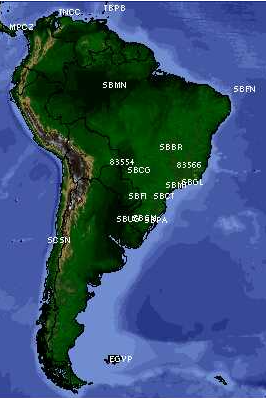

In [ ]:
nome_estacao = 'SBMT'

# Exemplos de estações com sigla e código
# Galeão..........: SBGL ou 83746
# SP-Marte........: SBMT ou 83779
# BR..............: SBBR ou 83378
# Curitiba........: SBCT ou 83840
# Florianópolis...: SBFL ou 83899
# Uberlândia......:SBUL ou 83525

**DATA**

In [ ]:
ano = 2024
mes = 9
dia = 19
hor = 0

# **PARTE 2):** Baixando os dados

**Baixando os dados da radiossondagem em formato de tabela (DataFrame)**

In [ ]:
# exibe a data escolhida
print(ano, mes, dia, hor)

2024 9 19 0


In [ ]:
# exibe a sigla da estação
print(nome_estacao)

SBMT


In [ ]:
df_estacao = WyomingUpperAir.request_data(datetime(ano, mes, dia, hor), nome_estacao)

**Exibindo a tabela de dados**

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,937.0,722,17.2,15.0,120.0,6.0,-5.196152,3.000000,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
1,925.0,827,16.6,15.1,110.0,10.0,-9.396926,3.420201,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
2,880.0,1250,13.6,13.6,51.0,11.0,-8.548606,-6.922524,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
3,866.0,1386,14.8,11.2,32.0,11.0,-5.829112,-9.328529,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
4,858.0,1465,17.8,8.8,21.0,11.0,-3.942047,-10.269385,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,15.0,28416,-49.9,-82.9,115.0,2.0,-1.812616,0.845237,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
78,14.0,28867,-50.6,-82.9,100.0,12.0,-11.817693,2.083778,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
79,13.7,29009,-50.9,-82.9,78.0,13.0,-12.715919,-2.702852,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
80,13.0,29352,-48.3,-82.9,25.0,16.0,-6.761892,-14.500925,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52


**Exibindo uma coluna da tabela de dados**

In [ ]:
df_estacao['temperature']

,temperature
0,17.2
1,16.6
2,13.6
3,14.8
4,17.8
...,...
77,-49.9
78,-50.6
79,-50.9
80,-48.3


**Plotando gráfico:** temperatura do ar

<Axes: >

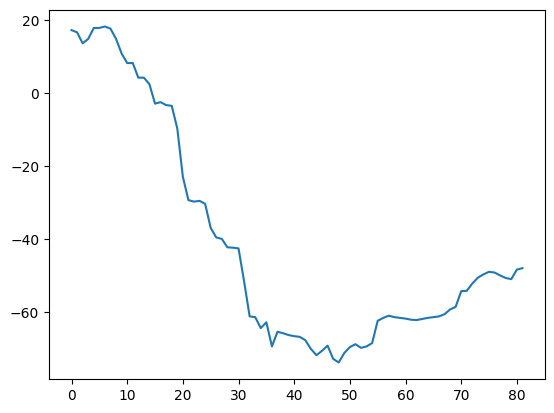

In [ ]:
# plotando de maneira simples
df_estacao['temperature'].plot()

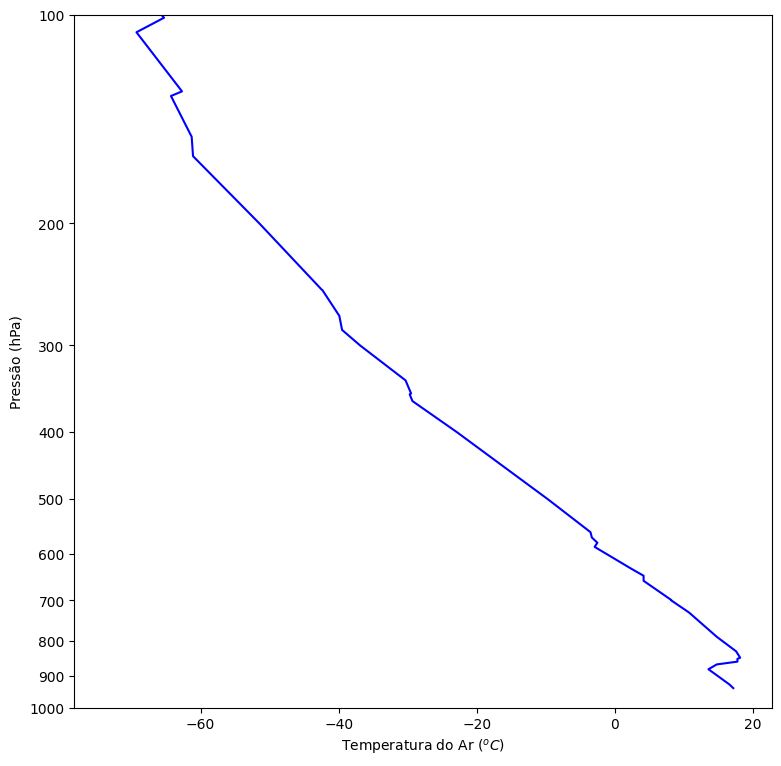

In [ ]:
# plotando de uma maneira mais completa
from matplotlib.ticker import (MultipleLocator, NullFormatter, ScalarFormatter)

fig, ax = plt.subplots(figsize=(9, 9))

# perfil de temperatura
ax.semilogy(df_estacao['temperature'], df_estacao['pressure'], color='blue')

# formatação dos eixos
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

# ticks no eixo y
ax.set_yticks(np.linspace(100, 1000, 10))

# limite em y (imitando o limite do Skew-T)
ax.set_ylim(100, 1000)

# inverter eixo y
plt.gca().invert_yaxis()

ax.set_ylabel('Pressão (hPa)')
ax.set_xlabel('Temperatura do Ar ($^{o}C$)')

plt.show()

# **PARTE 4):** Tratamento dos dados

**Eliminando dados NaN (*Not A Number* = Não é número)**

In [ ]:
# retirar nan da tabela
df_estacao = df_estacao.dropna()

In [ ]:
# mostrando a tabela
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,937.0,722,17.2,15.0,120.0,6.0,-5.196152,3.000000,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
1,925.0,827,16.6,15.1,110.0,10.0,-9.396926,3.420201,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
2,880.0,1250,13.6,13.6,51.0,11.0,-8.548606,-6.922524,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
3,866.0,1386,14.8,11.2,32.0,11.0,-5.829112,-9.328529,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
4,858.0,1465,17.8,8.8,21.0,11.0,-3.942047,-10.269385,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16.0,27995,-49.1,-82.9,170.0,10.0,-1.736482,9.848078,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
77,15.0,28416,-49.9,-82.9,115.0,2.0,-1.812616,0.845237,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
78,14.0,28867,-50.6,-82.9,100.0,12.0,-11.817693,2.083778,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
79,13.7,29009,-50.9,-82.9,78.0,13.0,-12.715919,-2.702852,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52


In [ ]:
# descrevendo as estatísticas básicas
df_estacao.describe()

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station_number,time,latitude,longitude,elevation,pw
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81,8.100000e+01,8.100000e+01,81.0,8.100000e+01
mean,260.391358,14989.679012,-40.845679,-62.467901,188.802469,23.864198,14.747379,4.310897,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
min,13.000000,722.000000,-73.700000,-90.700000,2.000000,1.000000,-20.284442,-14.500925,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
25%,43.000000,7540.000000,-62.700000,-88.500000,105.000000,11.000000,-3.942047,-5.416335,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
50%,89.000000,17307.000000,-52.100000,-83.200000,240.000000,13.000000,4.000000,2.952019,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
75%,400.000000,21708.000000,-22.900000,-46.300000,255.000000,24.000000,19.938771,10.944645,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
max,937.000000,29352.000000,18.200000,15.100000,356.000000,96.000000,90.210492,32.833934,83779.0,2024-09-19 00:00:00,-2.352000e+01,-4.663000e+01,722.0,2.552000e+01
std,294.179990,8721.797871,30.623900,36.575534,97.632144,23.617659,27.498565,11.799217,0.0,NaN,1.429940e-14,7.864668e-14,0.0,1.072455e-14


In [ ]:
# selecionando as linhas com temperaturas < 29,2oC
df_estacao_novo = df_estacao[ df_estacao['temperature'] < 29.2]

In [ ]:
# mostrando a tabela
df_estacao_novo

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,937.0,722,17.2,15.0,120.0,6.0,-5.196152,3.000000,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
1,925.0,827,16.6,15.1,110.0,10.0,-9.396926,3.420201,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
2,880.0,1250,13.6,13.6,51.0,11.0,-8.548606,-6.922524,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
3,866.0,1386,14.8,11.2,32.0,11.0,-5.829112,-9.328529,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
4,858.0,1465,17.8,8.8,21.0,11.0,-3.942047,-10.269385,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16.0,27995,-49.1,-82.9,170.0,10.0,-1.736482,9.848078,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
77,15.0,28416,-49.9,-82.9,115.0,2.0,-1.812616,0.845237,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
78,14.0,28867,-50.6,-82.9,100.0,12.0,-11.817693,2.083778,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
79,13.7,29009,-50.9,-82.9,78.0,13.0,-12.715919,-2.702852,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52


In [ ]:
# mostrando o tipo do objeto "tabela"
type(df_estacao_novo)

pandas.core.frame.DataFrame

**Atribuindo as variáveis que serão utilizadas e inserindo unidades nos dados**
- **Values**: tranforma de DataFrame para vetor (array unidimensional)

In [ ]:
df_estacao['pressure']

,pressure
0,937.0
1,925.0
2,880.0
3,866.0
4,858.0
...,...
76,16.0
77,15.0
78,14.0
79,13.7


In [ ]:
df_estacao['pressure'].values

array([937. , 925. , 880. , 866. , 858. , 850. , 847. , 829. , 790. ,
       729. , 700. , 699. , 656. , 645. , 630. , 586. , 578. , 568. ,
       558. , 500. , 400. , 361. , 353. , 352. , 337. , 300. , 285. ,
       272. , 251. , 250. , 249. , 200. , 160. , 150. , 131. , 129. ,
       106. , 101. , 100. ,  93. ,  89. ,  86.8,  85. ,  80. ,  76.8,
        76. ,  75. ,  70. ,  67.7,  66. ,  65. ,  64.5,  61.4,  61. ,
        60. ,  54. ,  50. ,  47.8,  45. ,  44. ,  43. ,  41. ,  40.5,
        38. ,  36. ,  34.3,  34. ,  33. ,  31. ,  30. ,  26. ,  25.9,
        20. ,  18. ,  17. ,  16.3,  16. ,  15. ,  14. ,  13.7,  13. ])

In [ ]:
# registrando unidades
pressao = df_estacao['pressure'].values * units('hPa')
temperatura = df_estacao['temperature'].values * units('celsius')
orvalho = df_estacao['dewpoint'].values * units('celsius')
vento_u = df_estacao['u_wind'].values * units('m/s')
vento_v = df_estacao['v_wind'].values * units('m/s')

In [ ]:
# mostrando os valores de PRESSÃO
pressao

Magnitude,[937.0 925.0 880.0 866.0 858.0 850.0 847.0 829.0 790.0 729.0 700.0 699.0 656.0 645.0 630.0 586.0 578.0 568.0 558.0 500.0 400.0 361.0 353.0 352.0 337.0 300.0 285.0 272.0 251.0 250.0 249.0 200.0 160.0 150.0 131.0 129.0 106.0 101.0 100.0 93.0 89.0 86.8 85.0 80.0 76.8 76.0 75.0 70.0 67.7 66.0 65.0 64.5 61.4 61.0 60.0 54.0 50.0 47.8 45.0 44.0 43.0 41.0 40.5 38.0 36.0 34.3 34.0 33.0 31.0 30.0 26.0 25.9 20.0 18.0 17.0 16.3 16.0 15.0 14.0 13.7 13.0]
Units,hectopascal


In [ ]:
# mostrando os valores de TEMPERATURA
temperatura

Magnitude,[17.2 16.6 13.6 14.8 17.8 17.8 18.2 17.6 14.8 10.8 8.2 8.2 4.2 4.2 2.4 -2.9 -2.5 -3.3 -3.5 -9.7 -22.9 -29.3 -29.7 -29.5 -30.3 -36.9 -39.5 -39.9 -42.2 -42.3 -42.5 -51.5 -61.1 -61.3 -64.3 -62.7 -69.3 -65.3 -65.7 -66.2 -66.5 -66.7 -67.6 -70.0 -71.7 -70.5 -69.1 -72.7 -73.7 -71.1 -69.5 -68.7 -69.7 -69.3 -68.4 -62.3 -61.5 -60.9 -61.3 -61.5 -61.7 -62.0 -62.1 -61.8 -61.5 -61.3 -61.1 -60.5 -59.2 -58.5 -54.2 -54.1 -52.1 -50.5 -49.6 -48.9 -49.1 -49.9 -50.6 -50.9 -48.3]
Units,degree_Celsius


In [ ]:
# mostrando os valores de TEMPERATURA DO PONTO DE ORVALHO
orvalho

Magnitude,[15.0 15.1 13.6 11.2 8.8 8.8 9.2 5.6 5.8 -5.2 3.8 4.0 2.1 -5.8 -7.6 -11.9 -23.5 -28.3 -42.5 -42.7 -49.9 -46.3 -54.7 -56.5 -59.3 -60.9 -60.5 -64.9 -68.1 -68.3 -67.5 -75.5 -78.1 -81.3 -84.3 -84.7 -86.3 -87.3 -86.7 -87.2 -87.5 -87.7 -88.0 -89.0 -89.7 -89.4 -89.1 -89.7 -90.7 -90.2 -89.9 -89.7 -89.7 -89.7 -89.6 -89.3 -88.5 -88.9 -89.0 -89.0 -89.0 -89.1 -89.1 -88.8 -88.5 -88.3 -88.2 -88.1 -87.7 -87.5 -85.2 -85.1 -84.1 -83.5 -83.2 -82.9 -82.9 -82.9 -82.9 -82.9 -82.9]
Units,degree_Celsius


In [ ]:
# mostrando os valores de VENTO ZONAL
vento_u

Magnitude,[-5.196152422706632 -9.396926207859085 -8.54860557602668 -5.829111906565254 -3.9420474449983027 -1.9101299543362336 -1.5309041105607197 0.767321211185382 6.180456898920654 12.666810842208058 12.802500789158705 12.802500789158705 15.300876095408565 16.073815785188387 16.80444767694963 18.541899450037466 19.052558883257646 19.5051062115978 19.896901741321003 20.506096654409877 35.70831958986452 41.72327345550543 43.577641164639005 43.577641164639005 46.025242672622014 52.5658516481257 63.03463657733947 73.2475245107762 90.21049159544721 89.2707989746613 89.2707989746613 78.9341801460163 71.29930094939306 67.7412394702387 56.298235413922846 55.31054707332771 39.6029588778518 32.147631570376774 30.07016386514907 19.9387713148063 16.74173180120754 13.703181864639017 11.468128620045885 12.990381056766578 3.4641016151377535 0.7071067811865475 0.7880107536067221 4.0 4.683914244512008 0.8715574274765794 -6.309340799861506 -3.3991869381244224 11.998172341876696 11.59110991546882 12.0 -0.31409547032250873 -6.5778483455013586 -7.187719590425635 -5.499999999999999 -4.788282006559362 -3.105828541230249 0.9848077530122081 2.8689142678891058 -9.969385657403151 -10.724622203665692 -16.741731801207536 -17.93150456565142 -11.59110991546882 -20.284442352070435 -16.91446717414635 -3.3646475863327696 -3.1449846427956807 2.121320343559643 -0.9587131702242402 -4.399923766742857 -2.494940289813112 -1.7364817766693028 -1.8126155740733 -11.817693036146496 -12.715918809539472 -6.761892187851191]
Units,meter/second


In [ ]:
# mostrando os valores de VENTO MERIDIONAL
vento_v

Magnitude,[2.9999999999999987 3.420201433256687 -6.922524301548212 -9.328529057720685 -10.269384691469218 -10.832885283134289 -10.892948756157274 -10.973204552858066 -10.286007608425345 -2.924363706470244 2.257426309670094 2.257426309670094 4.677947275563794 5.534658625771663 6.450623091815412 9.858902818503706 11.00000000000001 12.188143077363716 13.420629683297918 20.506096654409884 12.996765446375404 16.857296703716052 17.606509890547876 17.606509890547876 19.53655642446369 24.511859180960553 28.064828372230206 29.59392087985707 32.833933759264184 32.491913615938515 32.491913615938515 28.72969203935616 10.02046326912474 5.9265905068407605 8.91676450729317 8.760330042252939 10.611580849203346 11.069317251543326 10.944644586421393 -9.297601758295391 -2.9520190203378096 -6.101049646136996 -8.030070108914645 -7.500000000000002 2.0000000000000018 0.7071067811865477 0.6156614753256581 7.347880794884119e-16 5.20201377834176 9.961946980917455 9.010672487178912 10.461621679246688 -0.20942887724739756 -3.1058285412302435 2.204364238465236e-15 -8.994517443171862 -2.3941410032796817 -5.4163352083684355 -9.526279441628827 -13.155696691002717 -11.59110991546882 -0.17364817766692997 0.8771151141682113 4.648800879147693 8.99902653561155 2.952019020337815 1.5688033694578483 3.10582854123025 -5.4351999471529355 -6.156362579862039 -12.557035741757888 -12.613844441587954 -2.121320343559642 10.9581416790092 16.42073904691416 11.737771208805668 9.84807753012208 0.8452365234813987 2.0837781320031636 -2.702851980630873 -14.500924592586399]
Units,meter/second


**Criando um intervalo de níveis de pressão através de `np.arange()` entre os níveis de `1000 hPa a 100 hPa`**

In [ ]:
np.arange(1, 150, 1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149])

In [ ]:
niveis = np.arange(100, 1050, 50) * units('hPa')
niveis

Magnitude,[ 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000]
Units,hectopascal


In [ ]:
# quantidade de pontos da variável "niveis"
len(niveis)

19

In [ ]:
# mostrando a pressão
pressao

Magnitude,[937.0 925.0 880.0 866.0 858.0 850.0 847.0 829.0 790.0 729.0 700.0 699.0 656.0 645.0 630.0 586.0 578.0 568.0 558.0 500.0 400.0 361.0 353.0 352.0 337.0 300.0 285.0 272.0 251.0 250.0 249.0 200.0 160.0 150.0 131.0 129.0 106.0 101.0 100.0 93.0 89.0 86.8 85.0 80.0 76.8 76.0 75.0 70.0 67.7 66.0 65.0 64.5 61.4 61.0 60.0 54.0 50.0 47.8 45.0 44.0 43.0 41.0 40.5 38.0 36.0 34.3 34.0 33.0 31.0 30.0 26.0 25.9 20.0 18.0 17.0 16.3 16.0 15.0 14.0 13.7 13.0]
Units,hectopascal


**E esse intervalo de `niveis` vai servir para "filtrar" os dados de vento para o diagrama, com o uso de `mpcalc.resample_nn_1d()`.**

In [ ]:
len(pressao)

81

In [ ]:
len(niveis)

19

In [ ]:
niveis = mpcalc.resample_nn_1d(pressao, niveis)
niveis

[np.int64(38),
 np.int64(33),
 np.int64(31),
 np.int64(29),
 np.int64(25),
 np.int64(23),
 np.int64(20),
 np.int64(19),
 np.int64(18),
 np.int64(15),
 np.int64(13),
 np.int64(10),
 np.int64(9),
 np.int64(8),
 np.int64(5),
 np.int64(2),
 np.int64(0)]

**Extraindo o nome e data da estação**

In [ ]:
# para o título
nome = df_estacao['station'][0]
dia = df_estacao['time'][0]

In [ ]:
nome

'SBMT'

In [ ]:
dia

Timestamp('2024-09-19 00:00:00')

# **PARTE 5):** Plotando o gráfico

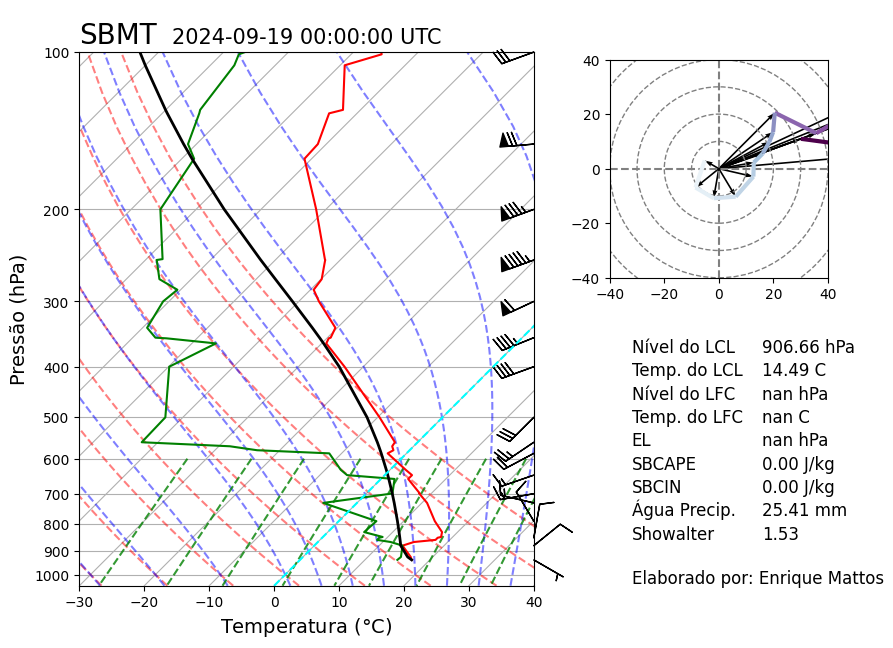

In [ ]:
# plotar painel termodinâmico com a função
plotar_painel(pressao,
              temperatura,
              orvalho,
              niveis,
              nome_estacao,
              dia,
              'Enrique Mattos',
              dir_output)

# Segue o link de um manual explicando os termos técnicos do Gráfico Skew-T Log-P: [Manual Skew-T](https://www.dropbox.com/s/sdm5etisv065lt7/Manual%20Informativo%20-%20SKEW-T.pdf?dl=0)

# **PARTE 6):** Gerando outros parâmetros meteorológicos e salvando num arquivo `CSV`

- Outro aspecto importante da análise de radiossondagens é o cálculo de algumas variáveis de interesse, como a própria Umidade Relativa (que é colocada na tabela no portal da Wyoming, mas que não é disponibilizada pelo Siphon), Temperatura Potencial e outras.

- O `mpcalc` também possui várias funções para o cálculo dessas variáveis e, novamente, a lista é extensa.

- Por exemplo, podemos calcular:
   - Umidade Relativa a partir da Temperatura do Ponto de Orvalho: `.relative_humidity_from_dewpoint()`, que precisa da temperatura do ar e temperatura do ponto de orvalho como argumentos (e precisa multiplicar por 100 ao final).
   

**- Umidade relativa**

In [ ]:
umidade_relativa = mpcalc.relative_humidity_from_dewpoint(temperatura, orvalho) * 100
umidade_relativa

Magnitude,[86.89573115645621 90.85068466090948 100.0 79.02211833387877 55.57798657140353 55.57798657140353 55.67957281989716 45.21027423461818 54.80681860879304 32.10951788439345 73.77537922228726 74.81994110590962 86.19781981169979 48.15383736408811 47.62866184751007 49.9107159446133 18.19217703520624 12.481241712965248 3.0853455355857 4.858628452795047 6.586670369251231 17.699358417769787 6.961275658354858 5.485954790269711 4.169855669026817 6.4747669224651405 8.889278906321007 5.1916248811156445 4.258807038806315 4.185430916511527 4.780368449077655 4.070628532540462 8.852142587516127 5.437603126573414 4.897874679035801 3.69967004213704 6.917881413527403 3.3349617778178082 3.912534530965788 3.8368375660695695 3.791801770217102 3.7619376116625 4.039706989717097 4.7371792459395285 5.333909336657194 4.7342716167135 4.093613234537173 6.176272826464093 5.965461094296883 4.462361130465749 3.747179017248997 3.4703620423203914 3.998364312685046 3.777414044337376 3.3880827683143466 1.564296306932667 1.627551567005571 1.4015437966955206 1.4496053206673678 1.4877156577638513 1.5269151007241597 1.5594473289572282 1.579960517221996 1.6036437123112872 1.627551567005571 1.6436151661980405 1.6304499109353907 1.5362482379485762 1.3973576494688174 1.3253187999332232 1.1665927440689288 1.1726263251836573 1.096666410327968 1.007161869707573 0.955029377365145 0.9270997073111779 0.9484302397253128 1.0392625972541532 1.1265499955011786 1.1663776687198542 0.8661858018313308]
Units,dimensionless


**- Razão de mistura**
- Razão de mistura a partir da Umidade Relativa: `.mixing_ratio_from_relative_humidity()`, cujos argumentos são pressão, temperatura e umidade relativa.

In [ ]:
razao_mistura = mpcalc.mixing_ratio_from_relative_humidity(pressao,
                                                           temperatura,
                                                           umidade_relativa)
razao_mistura

Magnitude,[-1.3817170817660995 -1.3501488738147769 -1.4311337063476763 -1.7844358447849806 -2.5695696217586765 -2.496673119926761 -2.2891949664576754 -7.043836029212614 -4.344948797140873 0.8250074215501034 -4.895933612993821 -4.428234978512511 -8.05568271270297 0.9964904329769035 0.757249600469474 0.45169802823565336 0.11860269643530583 0.0732443141554581 0.01667994734550953 0.018267432871915554 0.010161751625339669 0.017078485472400637 0.006506493750355027 0.0052291013449818425 0.003841330684207373 0.003514586547959307 0.0038974850826652614 0.002282333587685758 0.001591895003437267 0.0015540331890257133 0.0017450747935811267 0.0006771135008262509 0.0005657841413952327 0.00036111900920949436 0.00025078388965500654 0.0002379066935229331 0.00021974091927930584 0.00019354272930011652 0.00021721579780191753 0.00021393575261184112 0.0002120234979707194 0.0002098341831785624 0.00020315777592898264 0.00018045453140237835 0.00016559196546750158 0.00017670442348177633 0.00018904675475195658 0.00018168274109197887 0.00015641991435129835 0.00017588820620373924 0.00018866154291812223 0.0001971799794085288 0.00020713863594891782 0.00020849737742184698 0.00021586330757462213 0.0002532704404723056 0.0003159345793993172 0.0003075684338235606 0.00032088046712014416 0.0003281770530398501 0.0003358131982881786 0.00034590442298278537 0.00035017725231364927 0.0003939665923865947 0.000438884725699635 0.000477442739428497 0.000490341059868788 0.000514307370097788 0.000587892727958528 0.0006294250303894289 0.00108504274576568 0.001108124884541417 0.0017032590529191768 0.0020954230411824636 0.0023340933119947323 0.0025604255142468546 0.002608634849490981 0.0027833221003419934 0.002983084365648482 0.0030487275833277912 0.0032137380870762757]
Units,dimensionless


**- Temperatura virtual** `.virtual_temperature()`, cujos argumentos são temperatura e razão de mistura.

In [ ]:
temperatura_virtual = mpcalc.virtual_temperature(temperatura,
                                                 razao_mistura)
temperatura_virtual

Magnitude,[656.0227426678724 695.6994460745333 592.1656775965133 412.9453040824353 307.32040203990755 312.8082050415052 332.6562351472087 223.56683463885037 242.14912052222041 88.8218242475549 223.1076617162184 229.09607684353114 196.67418388144034 88.34243525719666 74.57503811993485 48.21149891141198 14.94246014574668 7.893831100541604 -0.8109935177774332 -6.827269562163792 -21.36985443379055 -26.81115039625763 -28.743420164937362 -28.729612143056727 -29.735146612755813 -36.3970748234689 -38.94863158036662 -39.577156753846936 -41.97688817347611 -42.082280769179704 -42.2557743379769 -51.40883749536957 -61.02711730780328 -61.25351605038455 -64.2681722293313 -62.66957481070972 -69.27277880178175 -65.27555309693628 -65.6726163378222 -66.17309475780868 -66.47337385204608 -66.67367423425156 -67.57462279917854 -69.9777214325052 -71.67972711158731 -70.47823802527896 -69.07655745607929 -72.67786793971757 -73.68103996370573 -71.07840266320045 -69.47665107574448 -68.67550117175242 -69.67438998320455 -69.27417134570402 -68.37314098965257 -62.267548921280536 -61.459368836827196 -60.86033230984475 -61.25869397322501 -61.45779489466847 -61.65685398997192 -61.9556209491538 -62.05509422037892 -61.74940919483865 -61.44356361559443 -61.238549776422644 -61.03683090645461 -60.43355751937551 -59.12359247321265 -58.41793033900689 -54.055754646743196 -53.95262222822413 -51.87153843611026 -50.21701309265001 -49.283581845867644 -48.55189116376337 -48.74567009610365 -49.52335791943173 -50.19767174557418 -50.48939960265207 -47.86218472683353]
Units,degree_Celsius


**- Temperatura potencial equivalente**

In [ ]:
temperatura_potencial_equiv = mpcalc.equivalent_potential_temperature(pressao,
                                                                      temperatura,
                                                                      orvalho)
temperatura_potencial_equiv

Magnitude,[329.167548009433 330.3631958826745 330.087248558637 328.74891838307155 329.12837349248383 330.26175471156955 331.84530508350133 328.0094100547407 330.7015580629335 322.27895508017616 334.12142018932497 334.60440792217446 334.3576633262206 326.9072453453599 325.6720451462573 323.5571752420904 320.05064990008003 319.5486280583448 319.19328628050755 321.8446569466538 325.5491768558007 326.91378745732254 328.0772170006989 328.56240282905685 331.5274614072711 333.40081916883827 334.6155416430256 338.45968687584525 342.874078165483 343.11504768132033 343.21916757478976 351.08756840177307 357.98761008742133 364.2956983158509 373.30085483780834 377.8171600146479 387.0875248649746 400.1680913334378 400.53645747327863 407.94230015955384 412.4998009731745 415.05809334517676 415.7299223874058 418.0533754440248 419.4175386242161 423.18082070665537 427.7207335112346 428.5388610693978 430.489037793292 439.28243868300007 444.69751217768345 447.43107722830223 451.5534826713905 453.2870616412146 457.4441048680547 485.471615594201 498.15244556649446 506.0281230604775 513.8619183602426 516.6842818621283 519.5984065657155 525.9709758612545 527.5685030470557 538.0278651126596 547.1830439111524 555.3256855190257 557.2479405711922 563.6135842888621 577.2859403487614 584.629881772521 621.2709397992461 622.2415218493162 676.1168547680091 701.863512031236 716.3287355125881 727.2807302124405 730.5041786893711 741.4615187440123 753.873477692288 757.5384397620128 777.9909610552556]
Units,kelvin


**- Unindo os parâmetros calculados as variáveis originais**

In [ ]:
df_estacao.insert(4, 'Umidade Relativa', umidade_relativa)
df_estacao.insert(5, 'Temperatura Virtual', temperatura_virtual)
df_estacao.insert(6, 'Temperatura Potencial Eq.', temperatura_potencial_equiv)

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,Umidade Relativa,Temperatura Virtual,Temperatura Potencial Eq.,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,937.0,722,17.2,15.0,86.895731,656.022743,329.167548,120.0,6.0,-5.196152,3.000000,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
1,925.0,827,16.6,15.1,90.850685,695.699446,330.363196,110.0,10.0,-9.396926,3.420201,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
2,880.0,1250,13.6,13.6,100.000000,592.165678,330.087249,51.0,11.0,-8.548606,-6.922524,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
3,866.0,1386,14.8,11.2,79.022118,412.945304,328.748918,32.0,11.0,-5.829112,-9.328529,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
4,858.0,1465,17.8,8.8,55.577987,307.320402,329.128373,21.0,11.0,-3.942047,-10.269385,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16.0,27995,-49.1,-82.9,0.948430,-48.745670,730.504179,170.0,10.0,-1.736482,9.848078,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
77,15.0,28416,-49.9,-82.9,1.039263,-49.523358,741.461519,115.0,2.0,-1.812616,0.845237,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
78,14.0,28867,-50.6,-82.9,1.126550,-50.197672,753.873478,100.0,12.0,-11.817693,2.083778,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
79,13.7,29009,-50.9,-82.9,1.166378,-50.489400,757.538440,78.0,13.0,-12.715919,-2.702852,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52


**- Renomeando as colunas da tabela**

In [ ]:
df_estacao.columns = ['Pressao Atm (hPa)',
                      'Altura (m)',
                      'Temperatura (C)',
                      'Temperatura Pto. de Orvalho (C)',
                      'Umidade Relativa (%)',
                      'Temperatura Virtual (K)',
                      'Temperatura Potencial Eq. (K)',
                      'Direcao do Vento',
                      'Velocidade (m/s)',
                      'Vento Zonal (m/s)',
                      'Vento Meridional (m/s)',
                      'Estacao',
                      'Codigo',
                      'Tempo',
                      'Latitude',
                      'Longitude',
                      'Elevacao',
                      'Agua Precipitavel']

In [ ]:
df_estacao

,Pressao Atm (hPa),Altura (m),Temperatura (C),Temperatura Pto. de Orvalho (C),Umidade Relativa (%),Temperatura Virtual (K),Temperatura Potencial Eq. (K),Direcao do Vento,Velocidade (m/s),Vento Zonal (m/s),Vento Meridional (m/s),Estacao,Codigo,Tempo,Latitude,Longitude,Elevacao,Agua Precipitavel
0,937.0,722,17.2,15.0,86.895731,656.022743,329.167548,120.0,6.0,-5.196152,3.000000,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
1,925.0,827,16.6,15.1,90.850685,695.699446,330.363196,110.0,10.0,-9.396926,3.420201,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
2,880.0,1250,13.6,13.6,100.000000,592.165678,330.087249,51.0,11.0,-8.548606,-6.922524,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
3,866.0,1386,14.8,11.2,79.022118,412.945304,328.748918,32.0,11.0,-5.829112,-9.328529,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
4,858.0,1465,17.8,8.8,55.577987,307.320402,329.128373,21.0,11.0,-3.942047,-10.269385,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16.0,27995,-49.1,-82.9,0.948430,-48.745670,730.504179,170.0,10.0,-1.736482,9.848078,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
77,15.0,28416,-49.9,-82.9,1.039263,-49.523358,741.461519,115.0,2.0,-1.812616,0.845237,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
78,14.0,28867,-50.6,-82.9,1.126550,-50.197672,753.873478,100.0,12.0,-11.817693,2.083778,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52
79,13.7,29009,-50.9,-82.9,1.166378,-50.489400,757.538440,78.0,13.0,-12.715919,-2.702852,SBMT,83779,2024-09-19,-23.52,-46.63,722.0,25.52


**- Salvando em um `DataFrame`**

In [ ]:
df_estacao.to_csv(f'{dir_output}{nome_estacao}_{dia}.csv', sep=';')